In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.ops import io_ops
import math
import time

## Histogram Equalization

In [7]:
#Histogram Equalization using tensorflow
def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype = tf.float32)
    histogram = tf.histogram_fixed_width(tf.cast(image,tf.float32), values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.to_float(cdf - cdf_min) * 255. / tf.cast(pix_cnt - 1,tf.float32))
    px_map = tf.cast(px_map, tf.uint8)

    eq_hist = tf.expand_dims(tf.gather_nd(px_map, tf.cast(image, tf.int32)), 2)
    return eq_hist

image_ph = tf.placeholder(tf.uint8, shape = [None, None, 1])
image_eq_hist = tf_equalize_histogram(image_ph) 



image = cv2.imread("bio0000_frame0000001.jpg", 0)
image = np.reshape(image, (image.shape[0], image.shape[1], 1))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    image_eq_hist_ = sess.run(image_eq_hist, feed_dict = {image_ph : image})

cv2.imshow("Histogram Equalization using opencv", cv2.equalizeHist(image))

cv2.imshow("Histogram Equalization using tensorflow", image_eq_hist_)
cv2.waitKey()
cv2.destroyAllWindows()


## Otsu Thresholding

In [27]:
def img_show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # we use open cv to read the image
    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')
    plt.show()

In [28]:
def Otsu_thresholding(gray):
    
    var = np.var(gray)
    mean = np.mean(gray)
    n = gray.shape[0]*gray.shape[1]  # total number of img pixels
    within_class_variances = []
    
    q = 0 
    mu1 = 0
    for t in range(254):
        p = np.count_nonzero(gray == t+1)/n
        mu1 = (q*mu1) + ((t+1)*p)
        q = q + p
        mu1 /= q
        mu2 = (mean - (q*mu1))/(1-q)
        
        between_class_variance = q*(1-q)*(mu1-mu2)**2
        within_class_variances.append(var-between_class_variance)
        
    threshold = within_class_variances.index(min(within_class_variances))
    print('threshold value by Otsu method: ' + str(threshold))
    
    img_show(gray)
    
    
    thresholded_img = np.zeros((gray.shape)).astype(np.uint8)
    indxs = np.where(gray >= threshold)
    for i,j in zip(indxs[0],indxs[1]):
        thresholded_img[i,j] = 255
    img_show(thresholded_img)

threshold value by Otsu method: 125


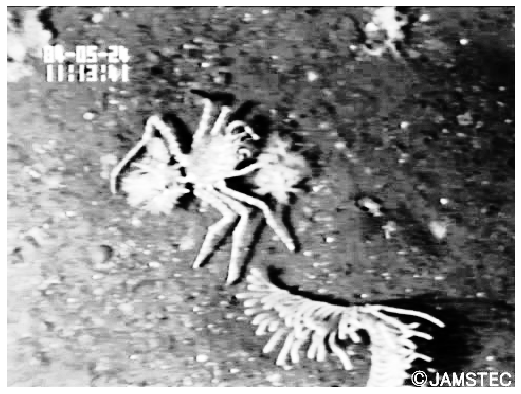

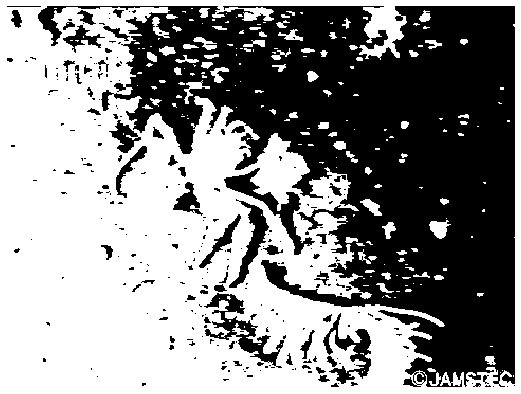

In [29]:
Otsu_thresholding(image_eq_hist_)